## Background

An autoencoder is a neural network that takes an input, encodes it into a lower-dimensional latent space through "encoding" layers, and then attempts to reconstruct the original input using "decoding" layers. Autoencoders are often used for dimensionality reduction.

We will train a 64x16x64 autoencoder on the digits dataset. 

### Load the digits dataset through sklearn using sklearn.datasets.load_digits().

In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()

### Split the data into training and validation sets.

We will use an 80-20 train-val split.

In [2]:
from sklearn.model_selection import train_test_split, KFold

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
np.random.seed(463)

X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2, shuffle=True)



3. Generate an instance of the NeuralNetwork class with a 64x16x64 autoencoder architecture.

We will create the NeuralNetwork inside the cross-validation loop.

In [3]:
from neural import NeuralNetwork, one_hot_encode_digits

nn_arch = [
    {
        'input_dim': 64,
        'output_dim': 16, 
        'activation': 'relu'
    },
    {
        'input_dim': 16, 
        'output_dim': 64, 
        'activation': 'relu'
    }#,
    #{
    #    'input_dim': 64,
    #    'output_dim': 10, 
    #    'activation': 'sigmoid'
    #}
]

lr = 0.01
seed = 462
batch_size = 128
epochs = 30
loss_function = 'mean_squared_error'#'binary_cross_entropy'


### 4. Train the autoencoder on the training data usig 5-fold cross validation.

We will perform grid search to ptimize hyperparameters, focusing on small learning rates and large numbers of epochs as guided by early results of training the model.

In [38]:
from itertools import product

# Higher learning rates were too unstable
lrs = [0.0005, 0.00025, 0.0001]
batch_sizes = [128, 512]
epochses = [50, 200, 1000] # My precious!

#best_mean_accuracy = 0.
best_val_loss = 1e8
best_params = {}
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=462)

i = 0
print('Performing hyperparameter grid search.')
for lr, batch_size, epochs in product(lrs, batch_sizes, epochses):

    mean_val_loss = 0
    for _, (train_idx, val_idx) in enumerate(kfold.split(X_train)):    
        
        net = NeuralNetwork(nn_arch,
                        lr,
                        462,
                        batch_size,
                        epochs,
                        'mean_squared_error')
        
        X_train_fold = X_train[train_idx]
        y_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = X_train[val_idx]

        per_epoch_loss_train, per_epoch_loss_val = net.fit(
            X_train_fold, 
            y_train_fold, 
            X_val_fold, 
            y_val_fold
            )
            
        mean_val_loss += per_epoch_loss_val[-1]

    mean_val_loss /= k

    if i % 10 == 0:
        # Print header every 10 models
        print('\nLR\tBatch Size\tEpochs\tVal loss\tBest val loss')

    print(f'{lr}\t{batch_size}\t\t{epochs}\t{round(mean_val_loss, 3)}\t\t{round(best_val_loss, 3)}')

    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_params = {
            'lr': lr,
            'batch_size': batch_size,
            'epochs': epochs
        }
    
    i += 1
    

Performing hyperparameter grid search.

LR	Batch Size	Epochs	Val loss	Best val loss
0.0005	128		50	6753.295		100000000.0
0.0005	128		200	5321.185		6753.295
0.0005	128		1000	5216.871		5321.185
0.0005	512		50	2007.963		5216.871
0.0005	512		200	1748.728		2007.963
0.0005	512		1000	1333.426		1748.728
0.00025	128		50	1067.123		1333.426
0.00025	128		200	750.431		1067.123
0.00025	128		1000	669.727		750.431
0.00025	512		50	492.206		669.727

LR	Batch Size	Epochs	Val loss	Best val loss
0.00025	512		200	281.714		492.206
0.00025	512		1000	168.336		281.714
0.0001	128		50	1832.29		168.336
0.0001	128		200	1635.937		168.336
0.0001	128		1000	1355.645		168.336
0.0001	512		50	759.257		168.336
0.0001	512		200	472.251		168.336
0.0001	512		1000	402.391		168.336


### Best Hyperparameters: 

lr: 0.00025

batch_size: 512

epochs: 5000

In [39]:
print('Best model performance:')
print(round(best_val_loss, 4), 'mean validation loss', k, 'cross-validation folds.\n')
print('Best hyperparameters:')
print('Learning rate:   ', best_params['lr'])
print('Batch size:   ', best_params['batch_size'])
print('Epochs:   ', best_params['epochs'])

Best model performance:
168.3361 mean validation loss 5 cross-validation folds.

Best hyperparameters:
Learning rate:    0.00025
Batch size:    512
Epochs:    1000


The best performance was observed after training for 1000 epochs using a learning rate of 0.00025 and batch size 512.

### Re-train best model architecture on full training set and evaluate on test set

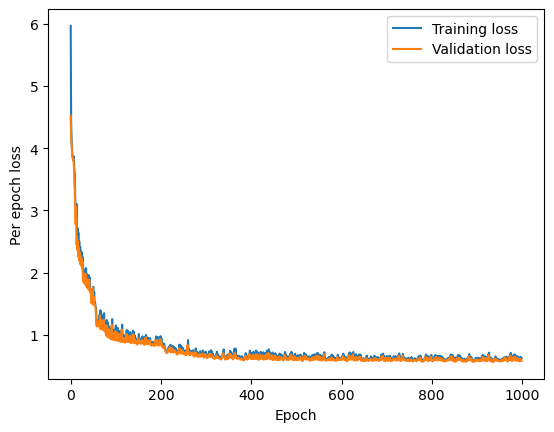

In [42]:
best_model = NeuralNetwork(nn_arch,
                    best_params['lr'],
                    462,
                    best_params['batch_size'],
                    best_params['epochs'],
                    'mean_squared_error')

per_epoch_loss_train, per_epoch_loss_val = best_model.fit(
    X_train, 
    X_train, 
    X_test, 
    X_test
    )

plt.plot(np.array(per_epoch_loss_train) / len(X_train))
plt.plot(np.array(per_epoch_loss_val) / len(X_test))
plt.legend(labels = ['Training loss', 'Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Per epoch loss')
plt.show()


### Visualize reconstructed handwritten digits

We will select 5 digits from the test set and compare our predictions to the original images.

True image


<Figure size 640x480 with 0 Axes>

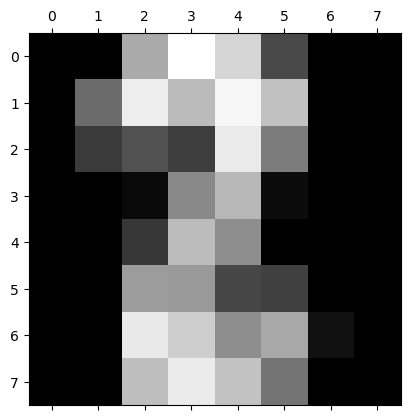

Predicted image


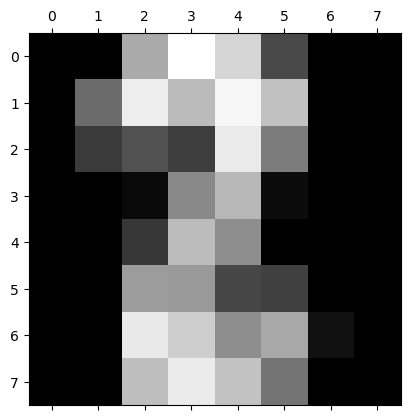

True image


<Figure size 640x480 with 0 Axes>

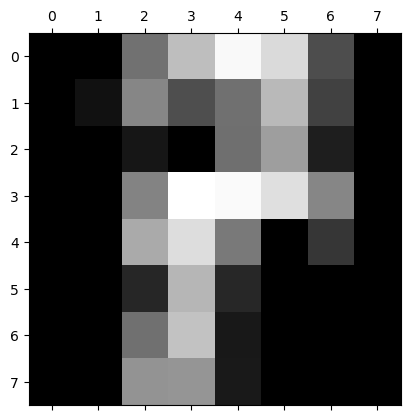

Predicted image


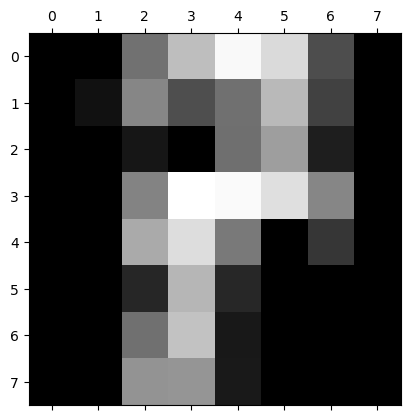

True image


<Figure size 640x480 with 0 Axes>

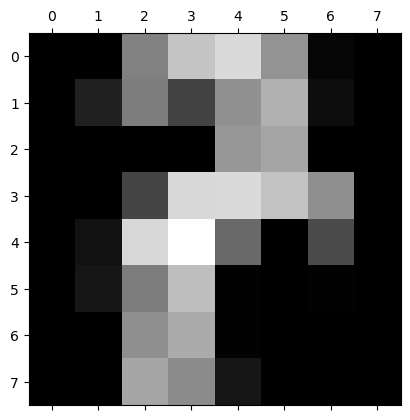

Predicted image


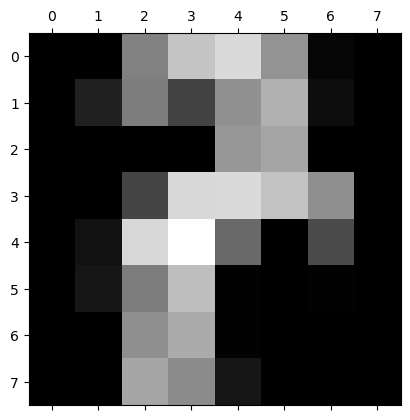

True image


<Figure size 640x480 with 0 Axes>

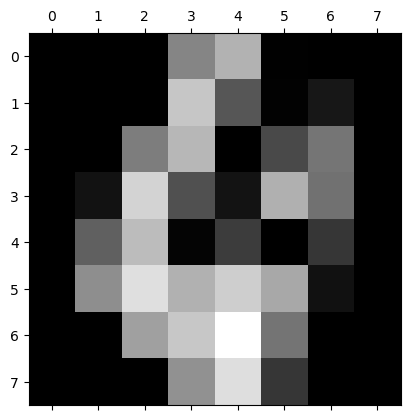

Predicted image


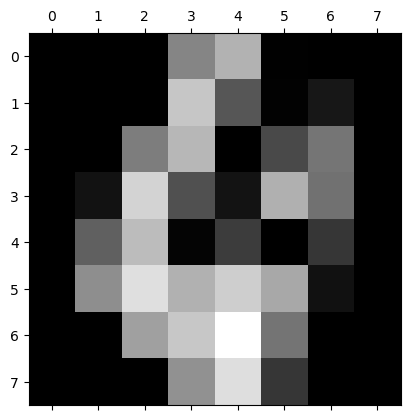

True image


<Figure size 640x480 with 0 Axes>

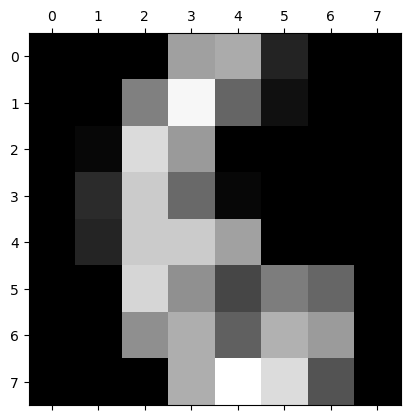

Predicted image


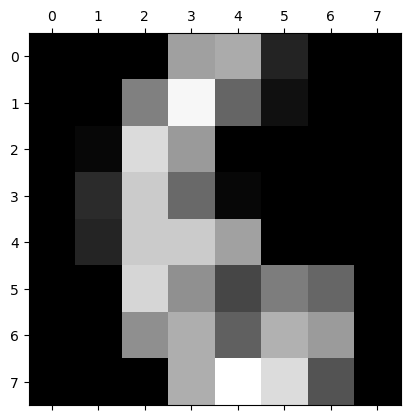

In [44]:
preds = best_model.predict(X_test).T

for i in np.random.randint(0, 100, 5):
    pred = preds[i].reshape((64, -1))
    plt.gray()
    print("True image")
    plt.matshow(pred.reshape(8,8))
    plt.show()
    
    print("Predicted image")
    plt.matshow(pred.reshape(8,8))
    plt.show()